In [1]:
# import the libraries as shown below

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

# Here Resnet50 model is implemented , please try with Resnet50V2 too.

from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet50 import ResNet50

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]
        
train_path = './Datasets/WhiteHot(Dataset)/Training/'

In [3]:
# Import the Resnet50 or Resnet50 V2 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

Rsnetv2 = ResNet50V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [4]:
# don't train existing weights
for layer in Rsnetv2.layers:
    layer.trainable = False

In [5]:
# useful for getting number of output classes
folders = glob('./Datasets/WhiteHot(Dataset)/Training/*')

In [6]:
len(folders)

2

In [7]:
# our layers - you can add more if you want
x = Flatten()(Rsnetv2.output)

In [8]:
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=Rsnetv2.input, outputs=prediction)

In [9]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

dense (Dense)                   (None, 1)            100353      flatten[0][0]                    
Total params: 23,665,153
Trainable params: 100,353
Non-trainable params: 23,564,800
__________________________________________________________________________________________________


In [10]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='RMSprop', #Adamax , RMSprop , Adagrad
  metrics=['accuracy','AUC','Precision','Recall'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

conv3_block1_2_relu (Activation (None, 28, 28, 128)  0           conv3_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv3_block1_0_conv (Conv2D)    (None, 28, 28, 512)  131584      conv3_block1_preact_relu[0][0]   
__________________________________________________________________________________________________
conv3_block1_3_conv (Conv2D)    (None, 28, 28, 512)  66048       conv3_block1_2_relu[0][0]        
__________________________________________________________________________________________________
conv3_block1_out (Add)          (None, 28, 28, 512)  0           conv3_block1_0_conv[0][0]        
                                                                 conv3_block1_3_conv[0][0]        
__________________________________________________________________________________________________
conv3_block2_preact_bn (BatchNo (None, 28, 28, 512)  2048        conv3_block1_out[0][0]           
__________

Total params: 23,665,153
Trainable params: 100,353
Non-trainable params: 23,564,800
__________________________________________________________________________________________________


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 50

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.5,1.0],
        fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory('./Datasets/WhiteHot(Dataset)/Training/',
                                                 target_size = (224, 224),
                                                 batch_size = 50,
                                                 class_mode = 'binary')

test_set = validation_datagen.flow_from_directory('./Datasets/WhiteHot(Dataset)/Testing/',
                                            target_size = (224, 224),
                                            batch_size = 50,
                                            class_mode = 'binary')

Found 1306 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [13]:
len(training_set)

27

In [14]:
training_set.class_indices

{'Fire': 0, 'No_Fire': 1}

In [15]:
imgs ,labels = next(training_set)

In [16]:
from matplotlib import pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr,axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

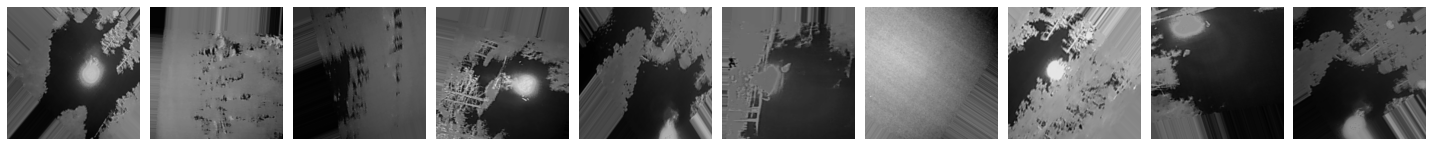

[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0.]


In [17]:
plotImages(imgs)
print(labels)

In [19]:
#Add checkpoints 
from keras.callbacks import ModelCheckpoint
#filepath='saved_models/models.h5'
filepath="./FirevsNonFire_Resnet50v2_WH_transfer_learning_model_weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #File name includes epoch and validation accuracy.
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [20]:
history = model.fit(training_set,
          steps_per_epoch= 1000 // batch_size,
          epochs=10, 
          validation_data=test_set,
          validation_steps= 200 // batch_size,
          callbacks=callbacks_list)

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 2.1294 - accuracy: 0.8598 - auc: 0.8693 - precision: 0.7695 - recall: 0.7419
Epoch 00001: val_accuracy improved from -inf to 0.99000, saving model to .\FirevsNonFire_Resnet50v2_WH_transfer_learning_model_weights-improvement-01-0.99.hdf5
20/20 [==============================] - 197s 10s/step - loss: 2.1294 - accuracy: 0.8598 - auc: 0.8693 - precision: 0.7695 - recall: 0.7419 - val_loss: 0.0160 - val_accuracy: 0.9900 - val_auc: 1.0000 - val_precision: 0.9813 - val_recall: 1.0000
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9665 - auc: 0.9823 - precision: 0.9533 - recall: 0.9408
Epoch 00002: val_accuracy improved from 0.99000 to 1.00000, saving model to .\FirevsNonFire_Resnet50v2_WH_transfer_learning_model_weights-improvement-02-1.00.hdf5
20/20 [==============================] - 192s 10s/step - loss: 0.1988 - accuracy: 0.9665 - auc: 0.9823 - precision: 0.9533 - recall: 0.9408 - 

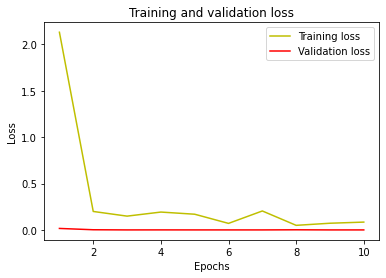

In [21]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

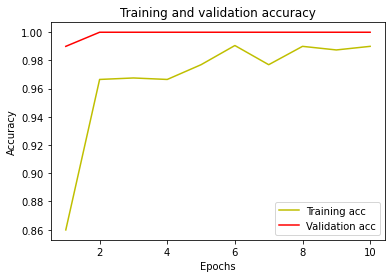

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

-----------------------------------------------------------------------------------------

In [ ]:
from tensorflow import keras

model = keras.models.load_model(' ')

In [ ]:
y_pred = model.predict(test_set) 

In [ ]:
y_pred

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

In [ ]:
misclassified=np.where(test_set!=y_pred)
misclassified

In [ ]:
print("Total Misclassified Samples: ",len(misclassified[0]))

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os 

image_directory = 'Datasets/Deep_Learning(Data)/New/Fire/'
firecount=0
nofirecount=0
for i in os.listdir(image_directory):
    img = image.load_img(image_directory+'//'+i,target_size=(224,224))
    plt.imshow(img)
    img = image.img_to_array(img)
    x = img.reshape((1,)+ img.shape)
    val = model.predict(x) 
    val = np.argmax(val, axis=1)
    plt.show() 
    if(val == 0 ):
        print("Fire")
        firecount+=1
    else:
        print("No Fire")
        nofirecount+=1
print("Fire Images:",firecount)
print("No Fire Images:",nofirecount)

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os 

image_directory = 'Datasets/Deep_Learning(Data)/New/No_Fire/'
firecount=0
nofirecount=0
for i in os.listdir(image_directory):
    img = image.load_img(image_directory+'//'+i,target_size=(224,224))
    plt.imshow(img)
    img = image.img_to_array(img)
    x = img.reshape((1,)+ img.shape)
    val = model.predict(x) 
    val = np.argmax(val, axis=1)
    plt.show() 
    if(val == 0 ):
        print("Fire")
        firecount+=1
    else:
        print("No Fire")
        nofirecount+=1
print("Fire Images:",firecount)
print("No Fire Images:",nofirecount)